In [28]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)

DATA_PATH = "../../data/raw_data/raw_spotify_song_info.csv"
EXPORT_DIR = "./artifacts"
os.makedirs(EXPORT_DIR, exist_ok=True)

Data Interpretation

In [25]:
df = pd.read_csv(DATA_PATH)
print("Rows, Cols:", df.shape)
display(df.head(5))
df.info()

Rows, Cols: (130663, 17)


,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130663 entries, 0 to 130662
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist_name       130663 non-null  object 
 1   track_id          130663 non-null  object 
 2   track_name        130662 non-null  object 
 3   acousticness      130663 non-null  float64
 4   danceability      130663 non-null  float64
 5   duration_ms       130663 non-null  int64  
 6   energy            130663 non-null  float64
 7   instrumentalness  130663 non-null  float64
 8   key               130663 non-null  int64  
 9   liveness          130663 non-null  float64
 10  loudness          130663 non-null  float64
 11  mode              130663 non-null  int64  
 12  speechiness       130663 non-null  float64
 13  tempo             130663 non-null  float64
 14  time_signature    130663 non-null  int64  
 15  valence           130663 non-null  float64
 16  popularity        13

Numeric Set

In [26]:
numeric_cols = df.select_dtypes(include = [np.number]).columns.tolist()

Correlation Matrix

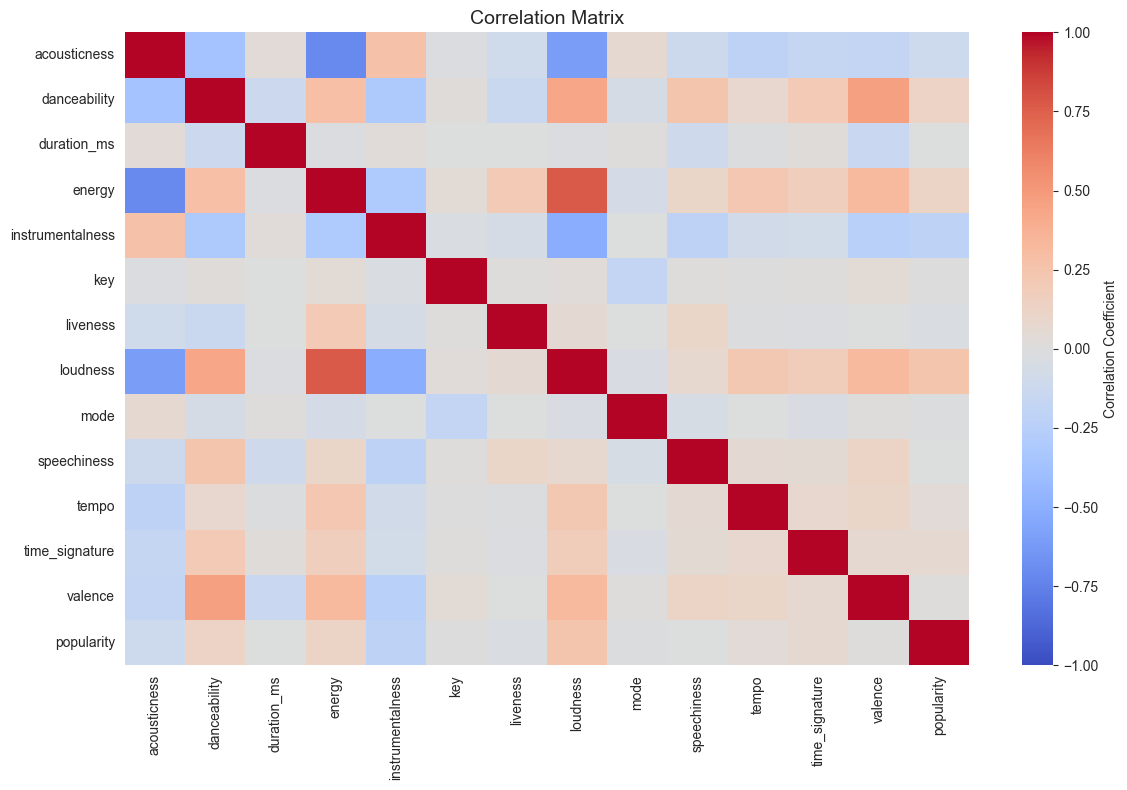

In [30]:
corr = df[numeric_cols].corr(numeric_only = True)

plt.figure(figsize = (12, 8))
sns.heatmap(corr, cmap='coolwarm',
            annot=False,
            center=0,
            vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

Feature Distribution & Skewness

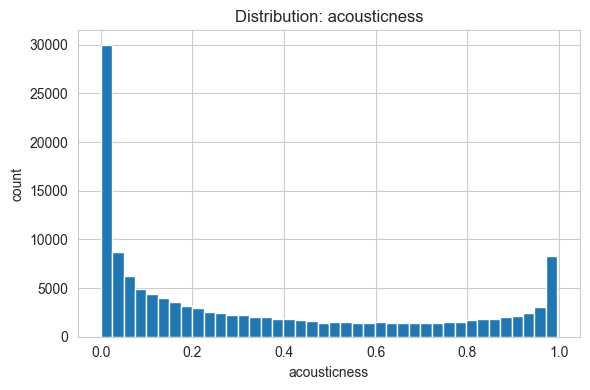

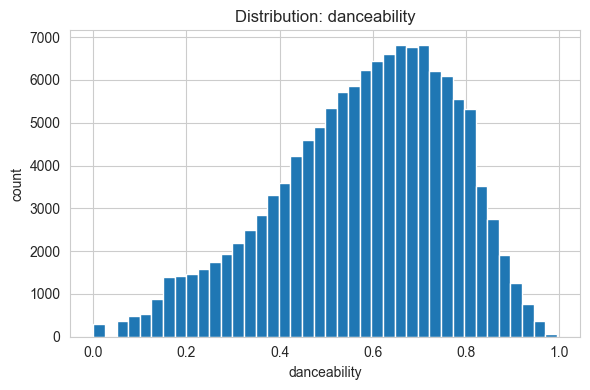

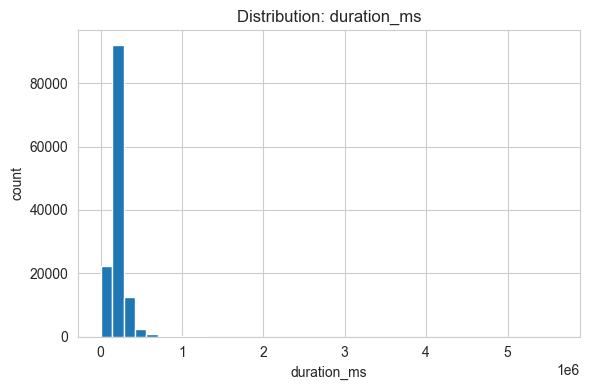

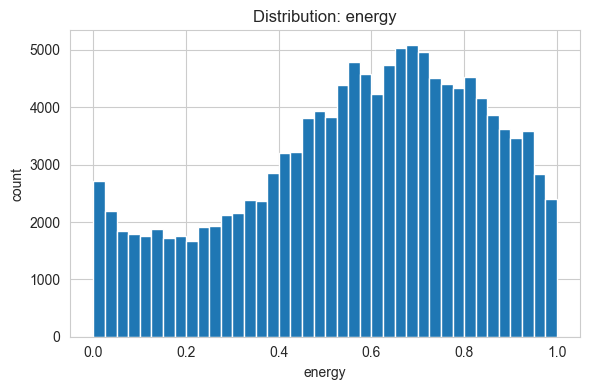

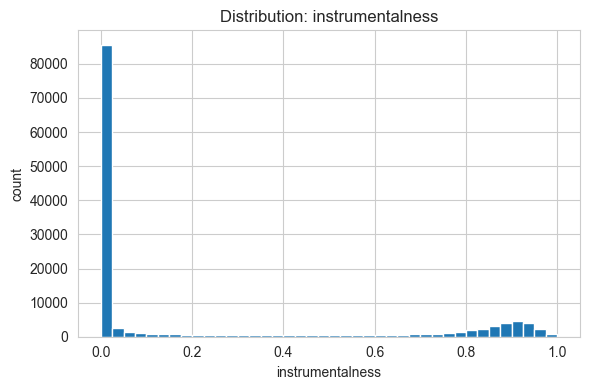

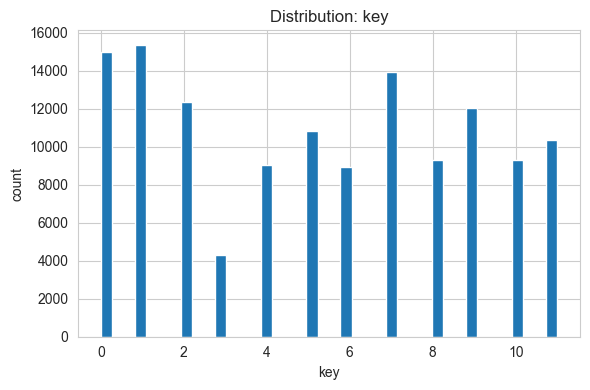

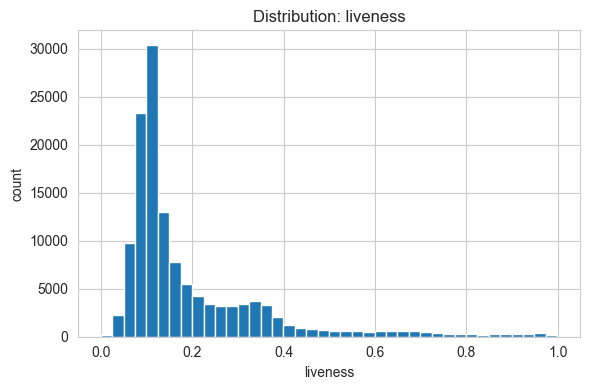

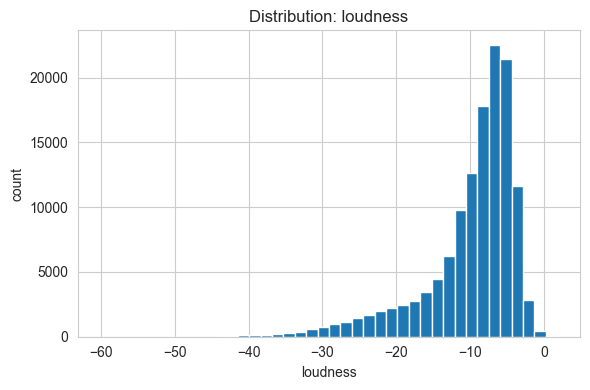

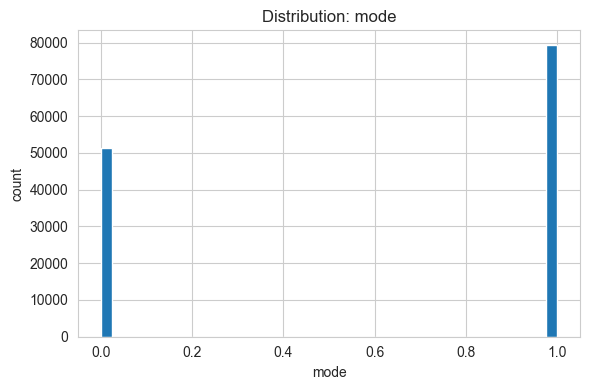

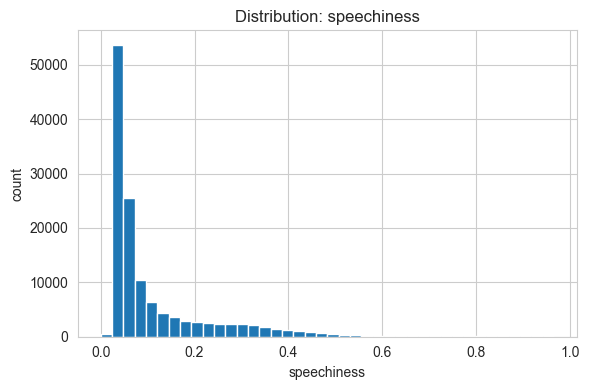

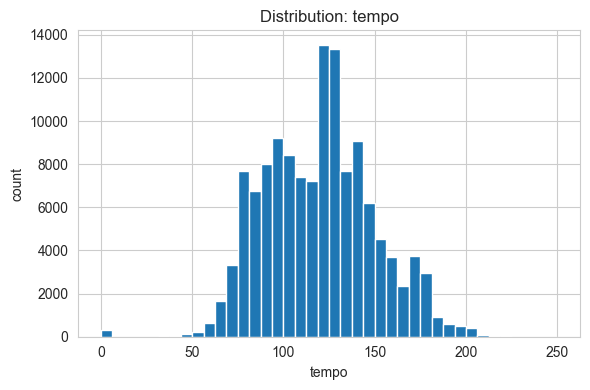

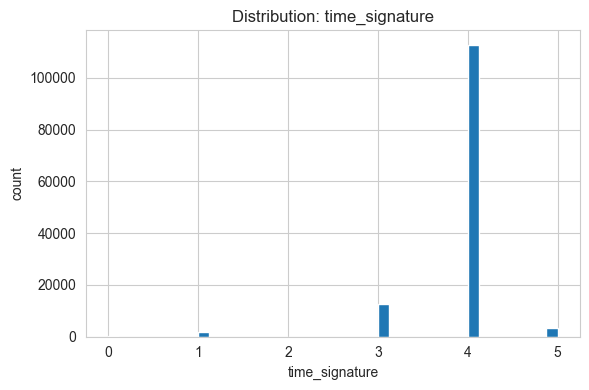

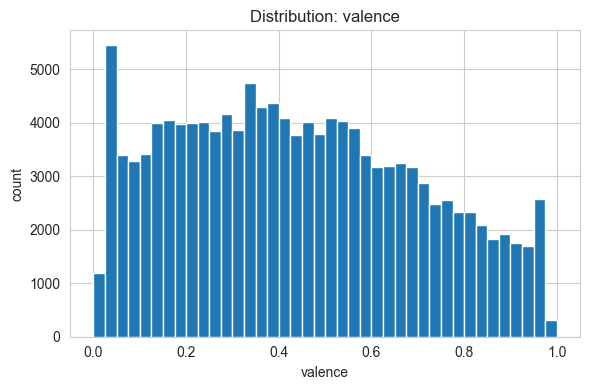

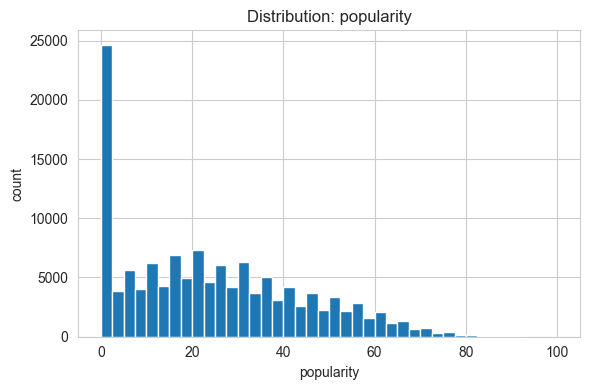

,skew
duration_ms,11.643607
speechiness,2.485561
liveness,2.297571
instrumentalness,1.169875
acousticness,0.684042
popularity,0.578231
valence,0.237064
tempo,0.152181
key,0.020392
energy,-0.436088


In [16]:
for c in numeric_cols:
    plt.figure(figsize=(6,4))
    df[c].dropna().plot(kind="hist", bins=40)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

sk = df[numeric_cols].skew(numeric_only=True)
display(sk.sort_values(ascending=False).to_frame("skew"))

Popular VS non-popular

In [27]:
popularity_threshold = 75
df["popular_flag"] = (df["popularity"] >= popularity_threshold).astype(int)

for c in numeric_cols:
   if c != "popularity":
    summary = df.groupby("popular_flag")[c].agg(["mean","median","std"]).reset_index()
    display(summary.style.set_caption(f"Summary of {c} by Popularity Flag"))

,popular_flag,mean,median,std
0,0,0.343311,0.204000,0.346232
1,1,0.236486,0.163500,0.233881


,popular_flag,mean,median,std
0,0,0.580516,0.604000,0.190148
1,1,0.705931,0.717000,0.130453


,popular_flag,mean,median,std
0,0,212689.528977,201905.000000,123568.047689
1,1,205260.062500,201803.000000,42370.523058


,popular_flag,mean,median,std
0,0,0.568708,0.603000,0.260868
1,1,0.633008,0.640500,0.160511


,popular_flag,mean,median,std
0,0,0.225636,0.000160,0.361156
1,1,0.012628,0.000000,0.081829


,popular_flag,mean,median,std
0,0,5.231617,5.000000,3.602112
1,1,5.268145,6.000000,3.680570


,popular_flag,mean,median,std
0,0,0.195090,0.124000,0.168030
1,1,0.168259,0.121000,0.120039


,popular_flag,mean,median,std
0,0,-10.003180,-8.006000,6.557135
1,1,-6.160443,-5.766000,2.516871


,popular_flag,mean,median,std
0,0,0.607962,1.000000,0.488207
1,1,0.578629,1.000000,0.494028


,popular_flag,mean,median,std
0,0,0.111905,0.055700,0.124424
1,1,0.126368,0.080350,0.110021


,popular_flag,mean,median,std
0,0,119.440669,120.026000,30.157702
1,1,123.745718,121.954500,30.122605


,popular_flag,mean,median,std
0,0,3.878223,4.000000,0.515855
1,1,3.978831,4.000000,0.243079


,popular_flag,mean,median,std
0,0,0.439324,0.420000,0.259360
1,1,0.479660,0.478500,0.215804


Fingerprint

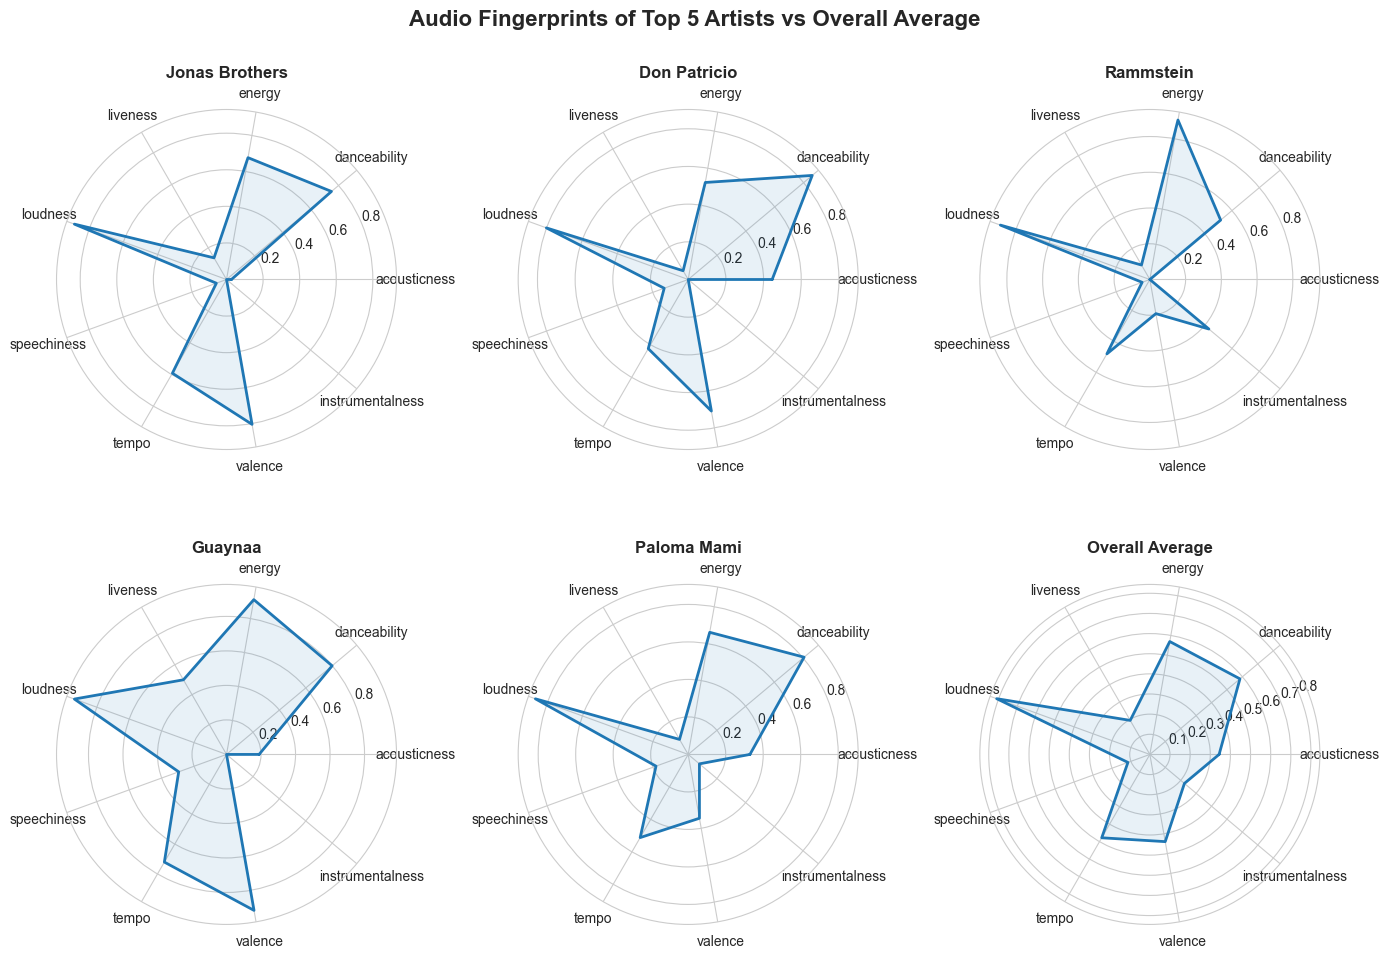

In [18]:
artist_col = "artist_name" if "artist_name" in df.columns else None
fingerprint_cols = [c for c in [
    "acousticness","danceability","energy","liveness","loudness",
    "speechiness","tempo","valence","instrumentalness"
] if c in df.columns]

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[fingerprint_cols] = scaler.fit_transform(df_scaled[fingerprint_cols])

top_artists = (
    df.groupby(artist_col)["popularity"]
      .mean()
      .sort_values(ascending=False)
      .head(5)
      .index.tolist()
)
artist_groups = top_artists + ["Overall Average"]
plt.figure(figsize=(14, 10))

for i, artist in enumerate(artist_groups, 1):
    if artist != "Overall Average":
        subset = df_scaled[df[artist_col] == artist][fingerprint_cols]
    else:
        subset = df_scaled[fingerprint_cols]  # global average

    vec = subset.mean().values.astype(float)
    labels = fingerprint_cols
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    vec = np.concatenate([vec, vec[:1]])
    angles = np.concatenate([angles, angles[:1]])

    ax = plt.subplot(2, 3, i, polar=True)
    ax.plot(angles, vec, linewidth=2)
    ax.fill(angles, vec, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f"{artist}", size=12, weight='bold')

plt.suptitle("Audio Fingerprints of Top 5 Artists vs Overall Average", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

Popularity drivers

R2: 0.1798 MAE: 14.453


,importance
loudness,0.158370
duration_ms,0.098059
energy,0.093832
acousticness,0.090493
tempo,0.088143
danceability,0.088000
valence,0.087656
speechiness,0.084754
liveness,0.078591
instrumentalness,0.074289


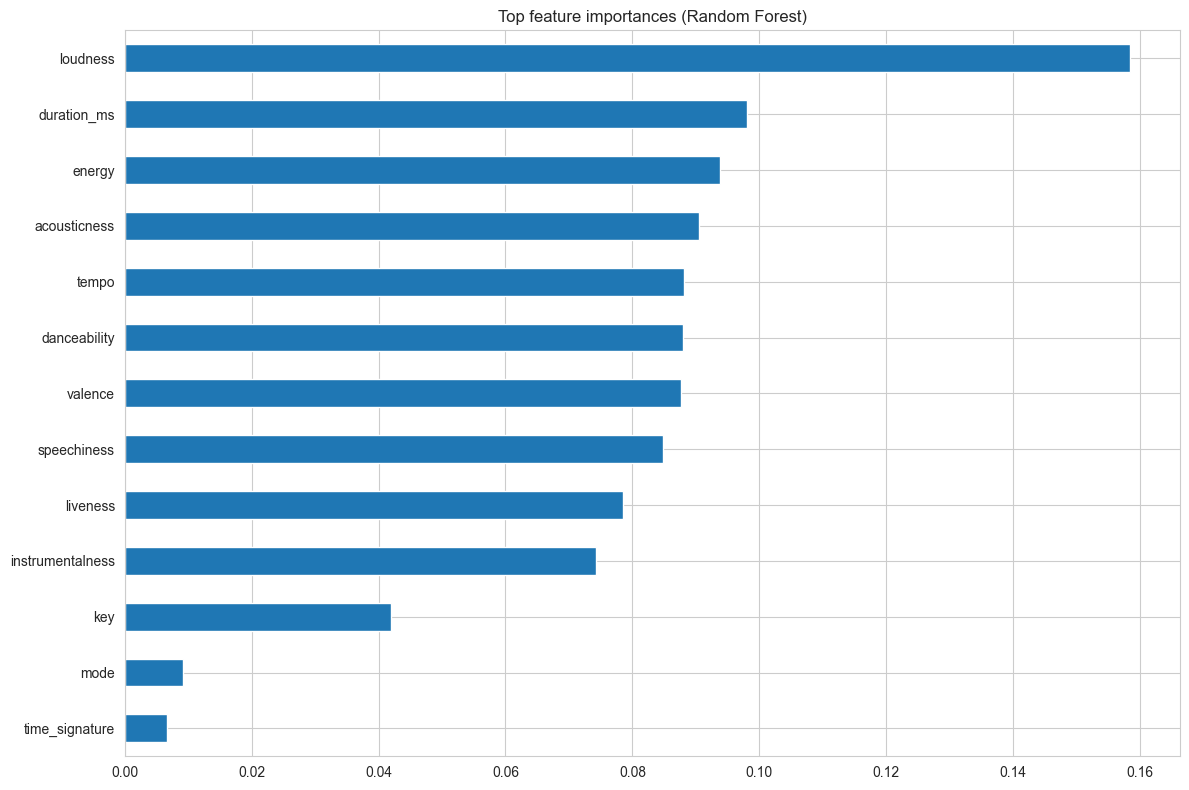

GradientBoosting  R²: 0.1573  MAE: 14.765


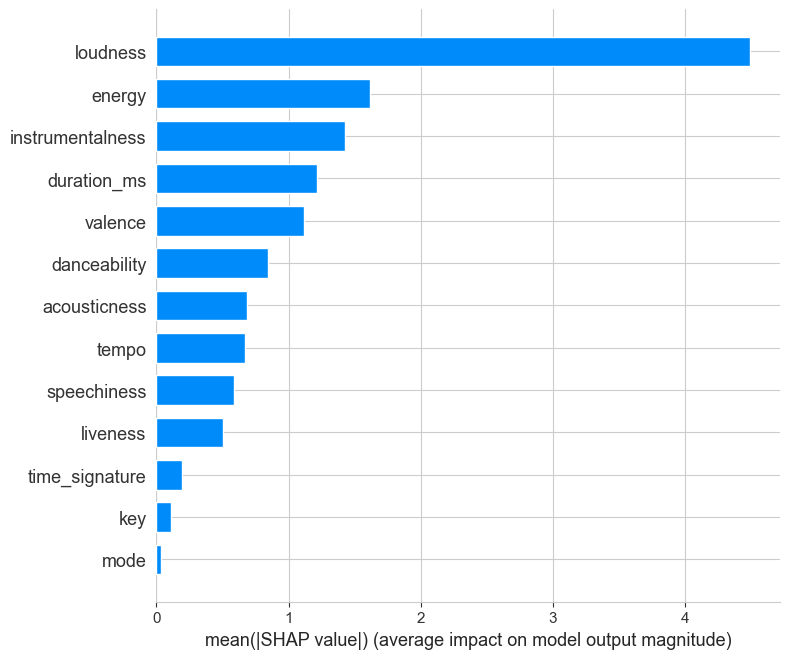

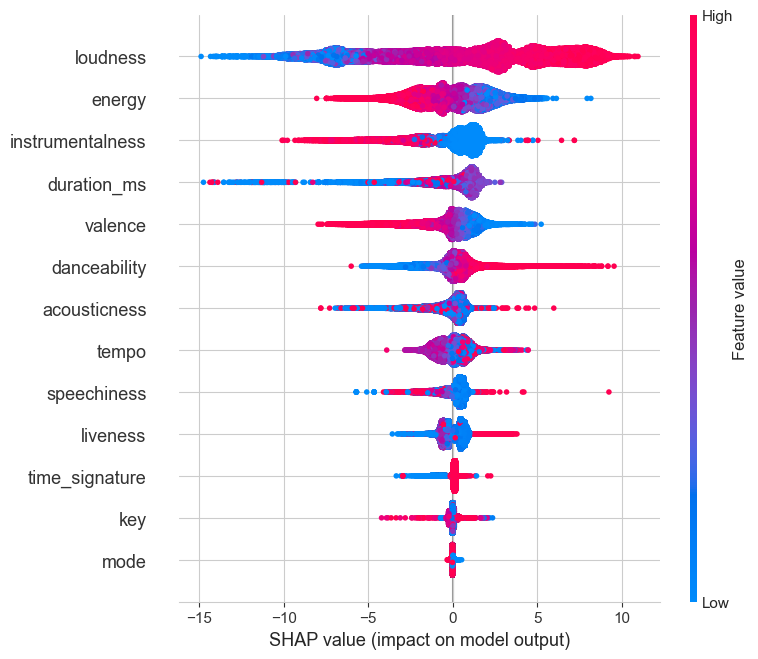

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap


X_cols = [c for c in numeric_cols if c != "popularity"]
X = df[X_cols].select_dtypes(include = [np.number]).fillna(0)
y = df["popularity"].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators = 250,
    random_state=42,
    n_jobs = -1
)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("R2:", round(r2_score(y_test, preds), 4), "MAE:", round(mean_absolute_error(y_test, preds), 3))

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.to_frame("importance"))

plt.figure(figsize = (12, 8))
importances.head(15).sort_values().plot(kind = "barh")
plt.title("Top feature importances (Random Forest)")
plt.tight_layout()
plt.show()

model_gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model_gb.fit(X_train, y_train)

preds = model_gb.predict(X_test)
print("GradientBoosting  R²:", round(r2_score(y_test, preds), 4),
      " MAE:", round(mean_absolute_error(y_test, preds), 3))

explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)

Unsupervised clustering

k = 2 - Silhouette score: 0.256


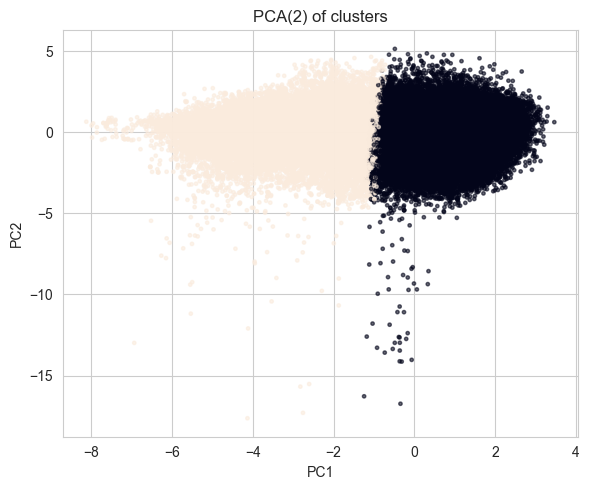

k = 3 - Silhouette score: 0.127


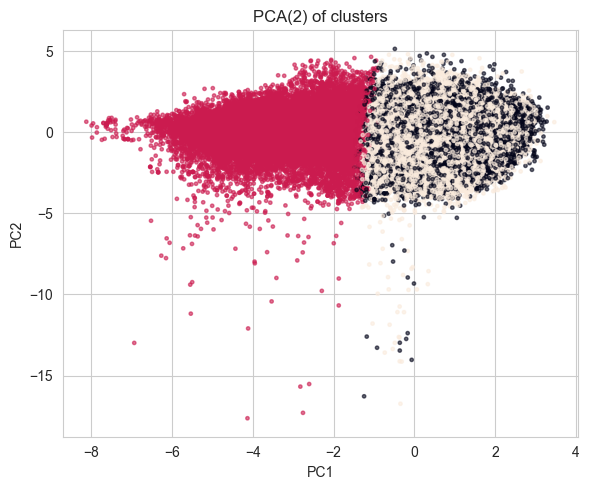

k = 4 - Silhouette score: 0.128


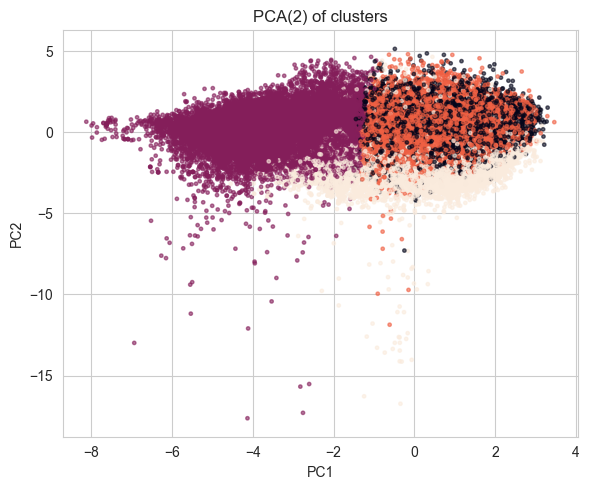

k = 5 - Silhouette score: 0.126


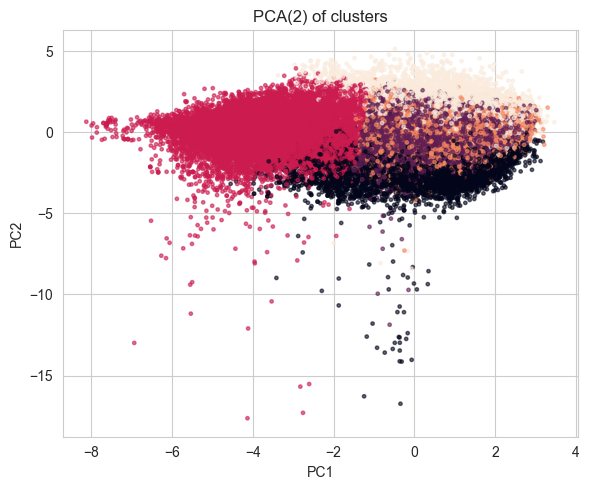

k = 6 - Silhouette score: 0.123


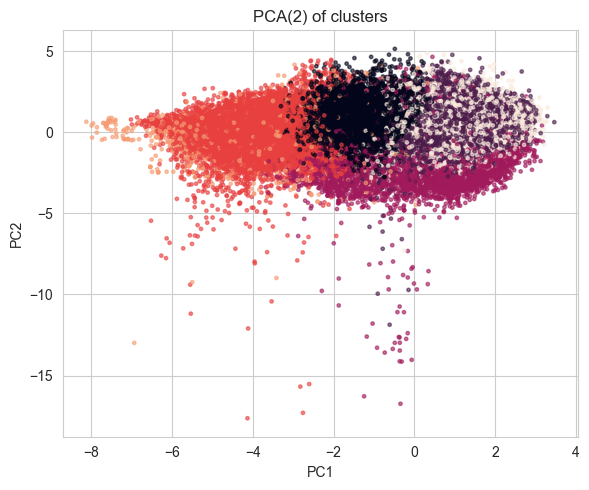

k = 7 - Silhouette score: 0.129


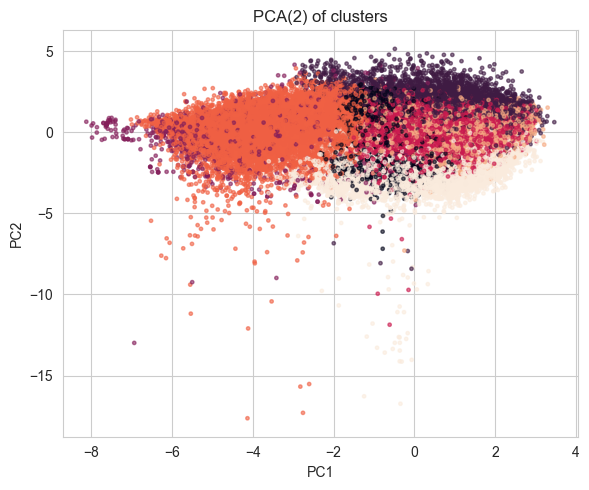

k = 8 - Silhouette score: 0.124


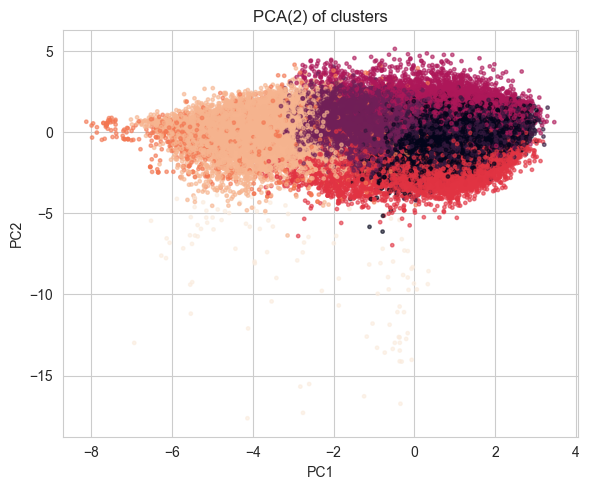

k = 9 - Silhouette score: 0.111


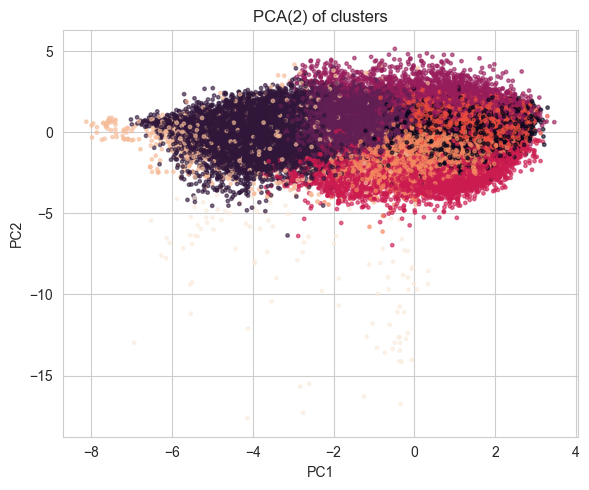

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_features = [c for c in numeric_cols if c != "popularity"]
Xc = df[cluster_features].select_dtypes(include=[np.number]).dropna()
if len(Xc) > 0 and Xc.shape[1] >= 2:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xc)
    ks, inertias = [], []
    for k in range (2, 10):
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(Xs)
        sil = silhouette_score(Xs, labels)
        print(f"k = {k} - Silhouette score:", round(sil, 3))

        X2 = PCA(n_components=2, random_state=42).fit_transform(Xs)
        plt.figure(figsize=(6,5))
        plt.scatter(X2[:,0], X2[:,1], s=6, alpha=0.6, c=labels)
        plt.title("PCA(2) of clusters")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()

A/B testing simulation

In [10]:
df_ab = df.copy()
df_ab["baseline_score"] = df_ab["popularity"]
if {"energy", "danceability"}.issubset(df_ab.columns):
    df_ab["variant_score"] = 0.7*df_ab["popularity"] + 0.15*df_ab["energy"] + 0.15*df_ab["danceability"]
else:
    df_ab["variant_score"] = df_ab["popularity"]

N = 50
base_top = df_ab.nlargest(N, "baseline_score")
var_top  = df_ab.nlargest(N, "variant_score")
overlap = len(set(base_top.index) & set(var_top.index)) / N
print(f"Top-{N} overlap between baseline and variant: {overlap:.2f}")

Top-50 overlap between baseline and variant: 0.90
